<a href="https://colab.research.google.com/github/JuanArmas/Proyecto_Final_CEIABD/blob/main/Proyecto_Final_JuanArmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Juan Airam Armas Alemán

Github: https://github.com/JuanArmas/Proyecto_Final_CEIABD/blob/main/Proyecto_Final_JuanArmas.ipynb

Drive:
https://drive.google.com/drive/folders/1FvCMo_QYz68XXPFFX4b4TJPTSollnmgB?usp=sharing


 Vamos a tratar de dar solución a este problema de regresión. El objetivo será predecir un valor numérico continuo, que en este caso será la cantidad de entradas de vehículos en un estacionamiento en función de diversas características, como la fecha, la hora del día, si es un día festivo o no, y si hay precipitaciones. La variable objetivo que trataremos de predecir será la cantidad de entradas de vehículos, (medida numérica continua), e intentaremos estimar este valor en función de las otras variables ya mencionadas.

In [60]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")

from google.colab import files, drive
from xgboost import XGBRegressor
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error, r2_score



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


#Carga de Datos

- Cargamos los datos previamente filtrados y almacenados en el drive.

- A su vez se carga el dataset de festivos y laborales que tenemos alojado también en drive.

- Al haberse creado un dataframe por aparcamiento, se solicita el nombre del aparcamiento para tramitarlo de manera individual, de esta manera facilitaremos tambien la puesta en producción.


In [3]:
# Cargar los datos
# nombre_aparcamiento = input("Introduce el nombre del aparcamiento: ")
nombre_aparcamiento = "mata"
# nombre_aparcamiento = "elder"
# nombre_aparcamiento = "rincón"
# nombre_aparcamiento = "sanapú"
# nombre_aparcamiento = "vegueta"
# nombre_aparcamiento = "san bernardo"
# nombre_aparcamiento = "metropol"
nombre_aparcamiento = nombre_aparcamiento.upper()
df = pd.read_csv(f"/content/drive/MyDrive/Proyecto_Final/Datasets_creados/{nombre_aparcamiento}.csv")
df_festivo_laboral = pd.read_csv('/content/drive/MyDrive/Proyecto_Final/Datasets_creados/dias_2023.csv')
df_precipitaciones = pd.read_csv('/content/drive/MyDrive/Proyecto_Final/Datasets_creados/precipitaciones_2023.csv')

Comprobaciones de que todo va como debiera y eliminación de las columnas "Estado" y "precipitaciones" que servían de guía.

In [4]:
filas_df_festivo_laboral = len(df_festivo_laboral)
filas_df_precipitaciones = len(df_precipitaciones)

print("columnas df festivo/laboral -> ",df_festivo_laboral.columns, "longitud -> ", filas_df_festivo_laboral)
print("columnas df precipitaciones -> ",df_precipitaciones.columns, "longitud -> ",filas_df_precipitaciones)

columnas df festivo/laboral ->  Index(['Fecha', 'Estado', 'Valor'], dtype='object') longitud ->  365
columnas df precipitaciones ->  Index(['fecha', 'precipitaciones', 'valor'], dtype='object') longitud ->  365


In [5]:
# Dividimos la columna 'Fecha' en 'year', 'month' y 'day' en df_festivo_laboral
df_festivo_laboral['year'] = df_festivo_laboral['Fecha'].astype(str).str[:4].astype(int)
df_festivo_laboral['month'] = df_festivo_laboral['Fecha'].astype(str).str[4:6].astype(int)
df_festivo_laboral['day'] = df_festivo_laboral['Fecha'].astype(str).str[6:].astype(int)

# Hacemos lo mismo para el df_precipitaciones
df_precipitaciones['year'] = df_precipitaciones['fecha'].astype(str).str[:4].astype(int)
df_precipitaciones['month'] = df_precipitaciones['fecha'].astype(str).str[4:6].astype(int)
df_precipitaciones['day'] = df_precipitaciones['fecha'].astype(str).str[6:].astype(int)

In [6]:
print("columnas df festivo/laboral -> ",df_festivo_laboral.columns)
print("columnas df precipitaciones -> ",df_precipitaciones.columns)

columnas df festivo/laboral ->  Index(['Fecha', 'Estado', 'Valor', 'year', 'month', 'day'], dtype='object')
columnas df precipitaciones ->  Index(['fecha', 'precipitaciones', 'valor', 'year', 'month', 'day'], dtype='object')


In [7]:
# Se eliminan las columnas sobrantes
df_festivo_laboral.drop(['Fecha','Estado'], axis=1, inplace=True)
df_precipitaciones.drop(['fecha','precipitaciones'], axis=1, inplace=True)

# Reordenamos las columnas
df_festivo_laboral = df_festivo_laboral.reindex(['year', 'month', 'day','Valor'], axis=1)
df_precipitaciones = df_precipitaciones.reindex(['year', 'month', 'day','valor'], axis=1)

print("columnas df festivo/laboral -> ",df_festivo_laboral.columns)
print("columnas df precipitaciones -> ",df_precipitaciones.columns)

columnas df festivo/laboral ->  Index(['year', 'month', 'day', 'Valor'], dtype='object')
columnas df precipitaciones ->  Index(['year', 'month', 'day', 'valor'], dtype='object')


In [8]:
df_festivo_laboral

,year,month,day,Valor
0,2023,1,1,0
1,2023,1,2,1
2,2023,1,3,1
3,2023,1,4,1
4,2023,1,5,1
...,...,...,...,...
360,2023,12,27,1
361,2023,12,28,1
362,2023,12,29,1
363,2023,12,30,0


In [9]:
df_precipitaciones

,year,month,day,valor
0,2023,1,1,0
1,2023,1,2,0
2,2023,1,3,0
3,2023,1,4,0
4,2023,1,5,0
...,...,...,...,...
360,2023,12,27,0
361,2023,12,28,0
362,2023,12,29,0
363,2023,12,30,0


# Inicio de la normalización de los datasets
- Se trabajan las fechas para tenerlas en un formato fácil de recorrer. El formato será año, mes, día y hora en variables independientes.
- Nos aseguramos de que las fechas son enteros y las redondeamos en última instancia.
- Reducimos la franja horaria a un rango de 0-23 horas, sin segundos ni milisegundos (Se implementa en el paso siguiente).

In [10]:
# Convertimos la columna 'EventTime' a datetime; ISO8601”-> Analizar cualquier cadena de tiempo
df['EventTime'] = pd.to_datetime(df['EventTime'], format='ISO8601')

# Extraemos la fecha y la hora como variables separadas
df['year'] = df['EventTime'].dt.year
df['month'] = df['EventTime'].dt.month
df['day'] = df['EventTime'].dt.day
df['hora'] = df['EventTime'].dt.time

# Convertimos la columna "hora" a string con el formato deseado y redondeamos siempre
hora_str = df['EventTime'].dt.strftime('%H')

# Redondeamos las horas
hora_str = [f'{round(int(x))}' for x in hora_str]

# Convertimos los strings a enteros
hora_int = [int(x) for x in hora_str]

- Se separan las horas de la fecha
- Se divide la fecha en año, mes y día
- Se reemplazan los valores categóricos por numéricos, en este caso se hace manualmente al ser pocos los cambios a realizar, entrada/salida y nombres de aparcamientos (1-7)
- Se reordenan las columnas del dataset para su mejor interpretación.

In [11]:
del df['EventTime']
# df = df.reindex(['APARCAMIENTO','fecha','hora','EventDesc'], axis=1)
df = df.reindex(['APARCAMIENTO','year','month','day','hora','EventDesc'], axis=1)

# Introducimos la fecha y hora numérica a la tabla
df['hora'] = hora_int

# Reemplazamos los valores categóricos por enteros
df = df.replace({"ENTRADA": 0, "SALIDA": 1, 'Entrada': 0, 'Salida': 1,'RINCÓN': 1, 'ELDER': 2, 'SAN BERNARDO': 3, 'SANAPÚ': 4, 'MATA': 5, 'VEGUETA': 6, 'METROPOL': 7})

In [12]:
df

,APARCAMIENTO,year,month,day,hora,EventDesc
0,5,2023,1,1,0,1
1,5,2023,1,1,0,1
2,5,2023,1,1,0,1
3,5,2023,1,1,0,1
4,5,2023,1,1,1,0
...,...,...,...,...,...,...
140130,5,2023,12,27,14,1
140131,5,2023,12,28,7,0
140132,5,2023,12,28,14,1
140133,5,2023,12,29,7,0


- Se crean dos columnas nuevas entrada/salida, extrayendo de la columna eventdesc el numero de entradas y salidas por día. Se borra la columna eventdesc.

In [13]:
# Dividir los valores de EventDesc en dos columnas nuevas: Entrada y Salida
df['Entrada'] = df['EventDesc'].apply(lambda x: 1 if x == 1 else 0)
df['Salida'] = df['EventDesc'].apply(lambda x: 1 if x == 0 else 0)

# Eliminar la columna EventDesc si ya no se necesita
df.drop('EventDesc', axis=1, inplace=True)

print(f"Mostrando datos de {nombre_aparcamiento}:")
df


Mostrando datos de MATA:


,APARCAMIENTO,year,month,day,hora,Entrada,Salida
0,5,2023,1,1,0,1,0
1,5,2023,1,1,0,1,0
2,5,2023,1,1,0,1,0
3,5,2023,1,1,0,1,0
4,5,2023,1,1,1,0,1
...,...,...,...,...,...,...,...
140130,5,2023,12,27,14,1,0
140131,5,2023,12,28,7,0,1
140132,5,2023,12,28,14,1,0
140133,5,2023,12,29,7,0,1


In [14]:
### PUNTO DE CONTROL DEL DATAFRAME ####
df.to_csv(f'dividido_Ent_sal_{nombre_aparcamiento}.csv', index=False)

- Se agrupan por fecha y hora las entradas y salidas para tener los totales en las 24h

In [15]:
df_agrupado = df.groupby(['APARCAMIENTO','year','month','day','hora']).sum().reset_index()

print(df_agrupado)

      APARCAMIENTO  year  month  day  hora  Entrada  Salida
0                5  2023      1    1     0        4       0
1                5  2023      1    1     1        2       2
2                5  2023      1    1     2        4       0
3                5  2023      1    1     3        3       0
4                5  2023      1    1    10        1       0
...            ...   ...    ...  ...   ...      ...     ...
6731             5  2023     12   31    19        3       3
6732             5  2023     12   31    20        3       9
6733             5  2023     12   31    21        3      12
6734             5  2023     12   31    22        1       0
6735             5  2023     12   31    23        1       1

[6736 rows x 7 columns]


In [16]:
### PUNTO DE CONTROL DEL DATAFRAME ####
df_agrupado.to_csv(f'Agrupado_{nombre_aparcamiento}.csv', index=False)

- Se unen los tres datasets, el de aparcamientos con el de festivos y precipitaciones por medio de la funcion merge

In [17]:
# Unir los conjuntos de datos por año, mes y día
df_final = pd.merge(df_agrupado, df_festivo_laboral, on=['year', 'month', 'day'], how='left')


In [18]:
# backup de el primer mergeo
df_backup_merge = df_final

In [19]:
df_final = pd.merge(df_final, df_precipitaciones, on=['year', 'month', 'day'], how='left')

- verificamos que se ha realizado bien la union de dataframes.

In [20]:
df_final.columns

Index(['APARCAMIENTO', 'year', 'month', 'day', 'hora', 'Entrada', 'Salida',
       'Valor', 'valor'],
      dtype='object')

- Creamos las últimas columnas en el dataframe para añadir los días festivos (0) ó laborales (1) y las precipitaciones diarias (precipitacion_NO =0 /precipitacion_SI = 1) del año 2023. Extraemos esta información de los dataframes que ya tenemos df_festivo_laboral y df_precipitaciones.
- Eliminamos las columnas Valor y valor ya que dejan de tener utilidad.

In [21]:
# Rellenar la columna 'lab_fest' con el valor correspondiente
df_final['fest_lab'] = df_final['Valor']
df_final['precipitaciones']= df_final['valor']

# Eliminamos las columnas 'Valor' y 'valor'ya que no son necesarias
df_final = df_final.drop(columns=['Valor','valor'])

In [22]:
df_final

,APARCAMIENTO,year,month,day,hora,Entrada,Salida,fest_lab,precipitaciones
0,5,2023,1,1,0,4,0,0,0
1,5,2023,1,1,1,2,2,0,0
2,5,2023,1,1,2,4,0,0,0
3,5,2023,1,1,3,3,0,0,0
4,5,2023,1,1,10,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6731,5,2023,12,31,19,3,3,0,0
6732,5,2023,12,31,20,3,9,0,0
6733,5,2023,12,31,21,3,12,0,0
6734,5,2023,12,31,22,1,0,0,0


In [23]:
### PUNTO DE CONTROL DEL DATAFRAME ####
df_final.to_csv(f'df_completo_{nombre_aparcamiento}.csv', index=False)

- Como curiosidad, averiguamos los valores máximos para las variables objetivo y la fila donde se encuentra.

In [24]:
valor_max_ent = df_final['Entrada'].max()
valor_max_ent_indx = df_final['Entrada'].idxmax()
valor_max_sal = df_final['Salida'].max()
valor_max_sal_indx = df_final['Salida'].idxmax()

print("valor_max Entrada->", valor_max_ent, " En la fila -> ", valor_max_ent_indx+2) #el +2 es para corregir la cabecera y el que empiece en index 0
print("valor_max Salida ->", valor_max_sal, " En la fila -> ", valor_max_sal_indx+2)

valor_max Entrada-> 52  En la fila ->  2143
valor_max Salida -> 55  En la fila ->  1458


- Verificamos que no hay valores nulos en el dataframe.
Si el resultadoes es TRUE es que si hay valores nulos en el dataframe, por lo que se deberán controlar. En nuestro caso no hay valores nulos, por lo que podemos continuar.


In [25]:
df_final.isnull().any().any()

False

# Histograma de las variables numéricas




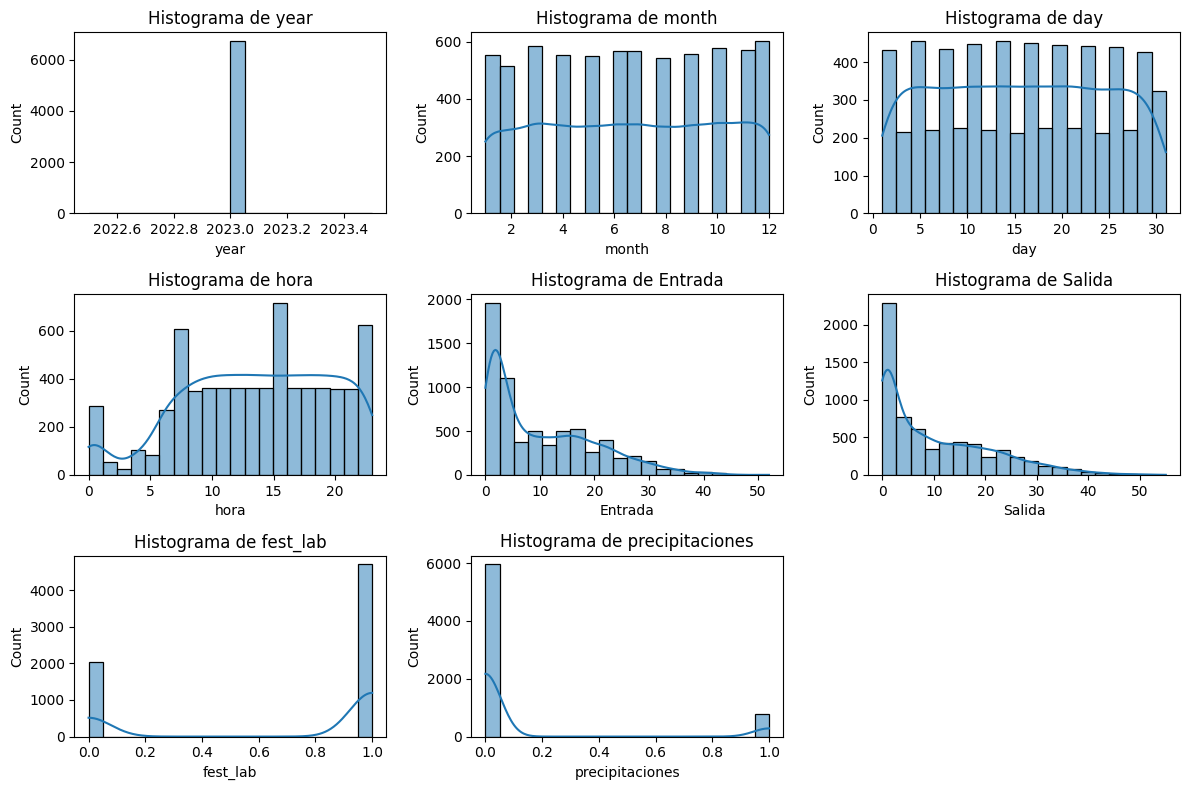

In [26]:
# Seleccionar las variables numéricas para crear histogramas
numeric_vars = ['year', 'month', 'day', 'hora', 'Entrada', 'Salida', 'fest_lab', 'precipitaciones']

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear histogramas para las variables numéricas
for i, var in enumerate(numeric_vars):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_final[var], bins=20, kde=True)
    plt.title(f'Histograma de {var}')

# Ajustar el diseño y mostrar los histogramas
plt.tight_layout()
plt.show()

# Matriz de correlación
- Veamos la correlación de variables con una matriz de correlación

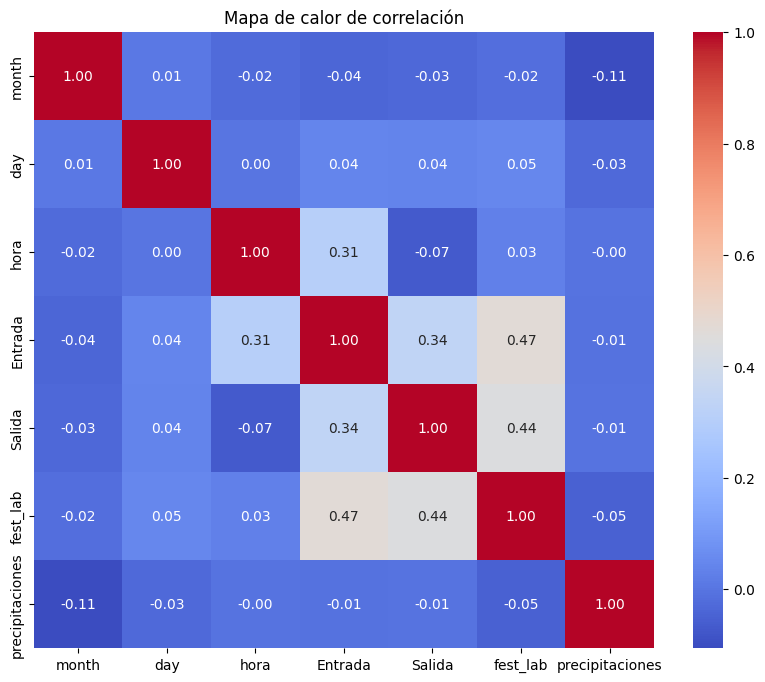

In [27]:
columnas = ['month', 'day', 'hora', 'Entrada', 'Salida', 'fest_lab', 'precipitaciones']

# Matriz de correlación
correlation_matrix = df_final[columnas].corr()

# Mostramos el mapa de calor de la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlación')
plt.show()

Vemos como las variables que más peso tienen como potencialmente objetivas son entrada y salida, como se había estimado. Nos centraremos en las entradas por ahora al ser la que más peso tiene.

# Gráfica de dispersión.
Generamos un gráfico de dispersión para explorar la relación que se da entre las entradas y las horas del día

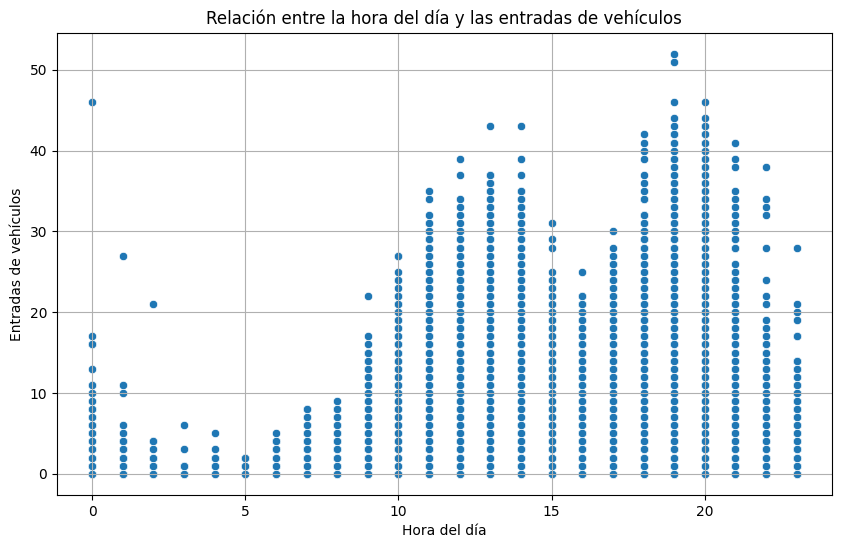

In [28]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión
sns.scatterplot(x='hora', y='Entrada', data=df_final)

# Agregar etiquetas y título
plt.xlabel('Hora del día')
plt.ylabel('Entradas de vehículos')
plt.title('Relación entre la hora del día y las entradas de vehículos')

# Mostrar el gráfico
plt.grid(True)
plt.show()


In [29]:
# # GRAFICA DE DISPERSION DE SALIDAS DE VEHICULOS
# # Configurar el tamaño de la figura
# plt.figure(figsize=(10, 6))

# # Crear el gráfico de dispersión
# sns.scatterplot(x='hora', y='Salida', data=df_final)

# # Agregar etiquetas y título
# plt.xlabel('Hora del día')
# plt.ylabel('salida de vehículos')
# plt.title('Relación entre la hora del día y las salida de vehículos')

# # Mostrar el gráfico
# plt.grid(True)
# plt.show()

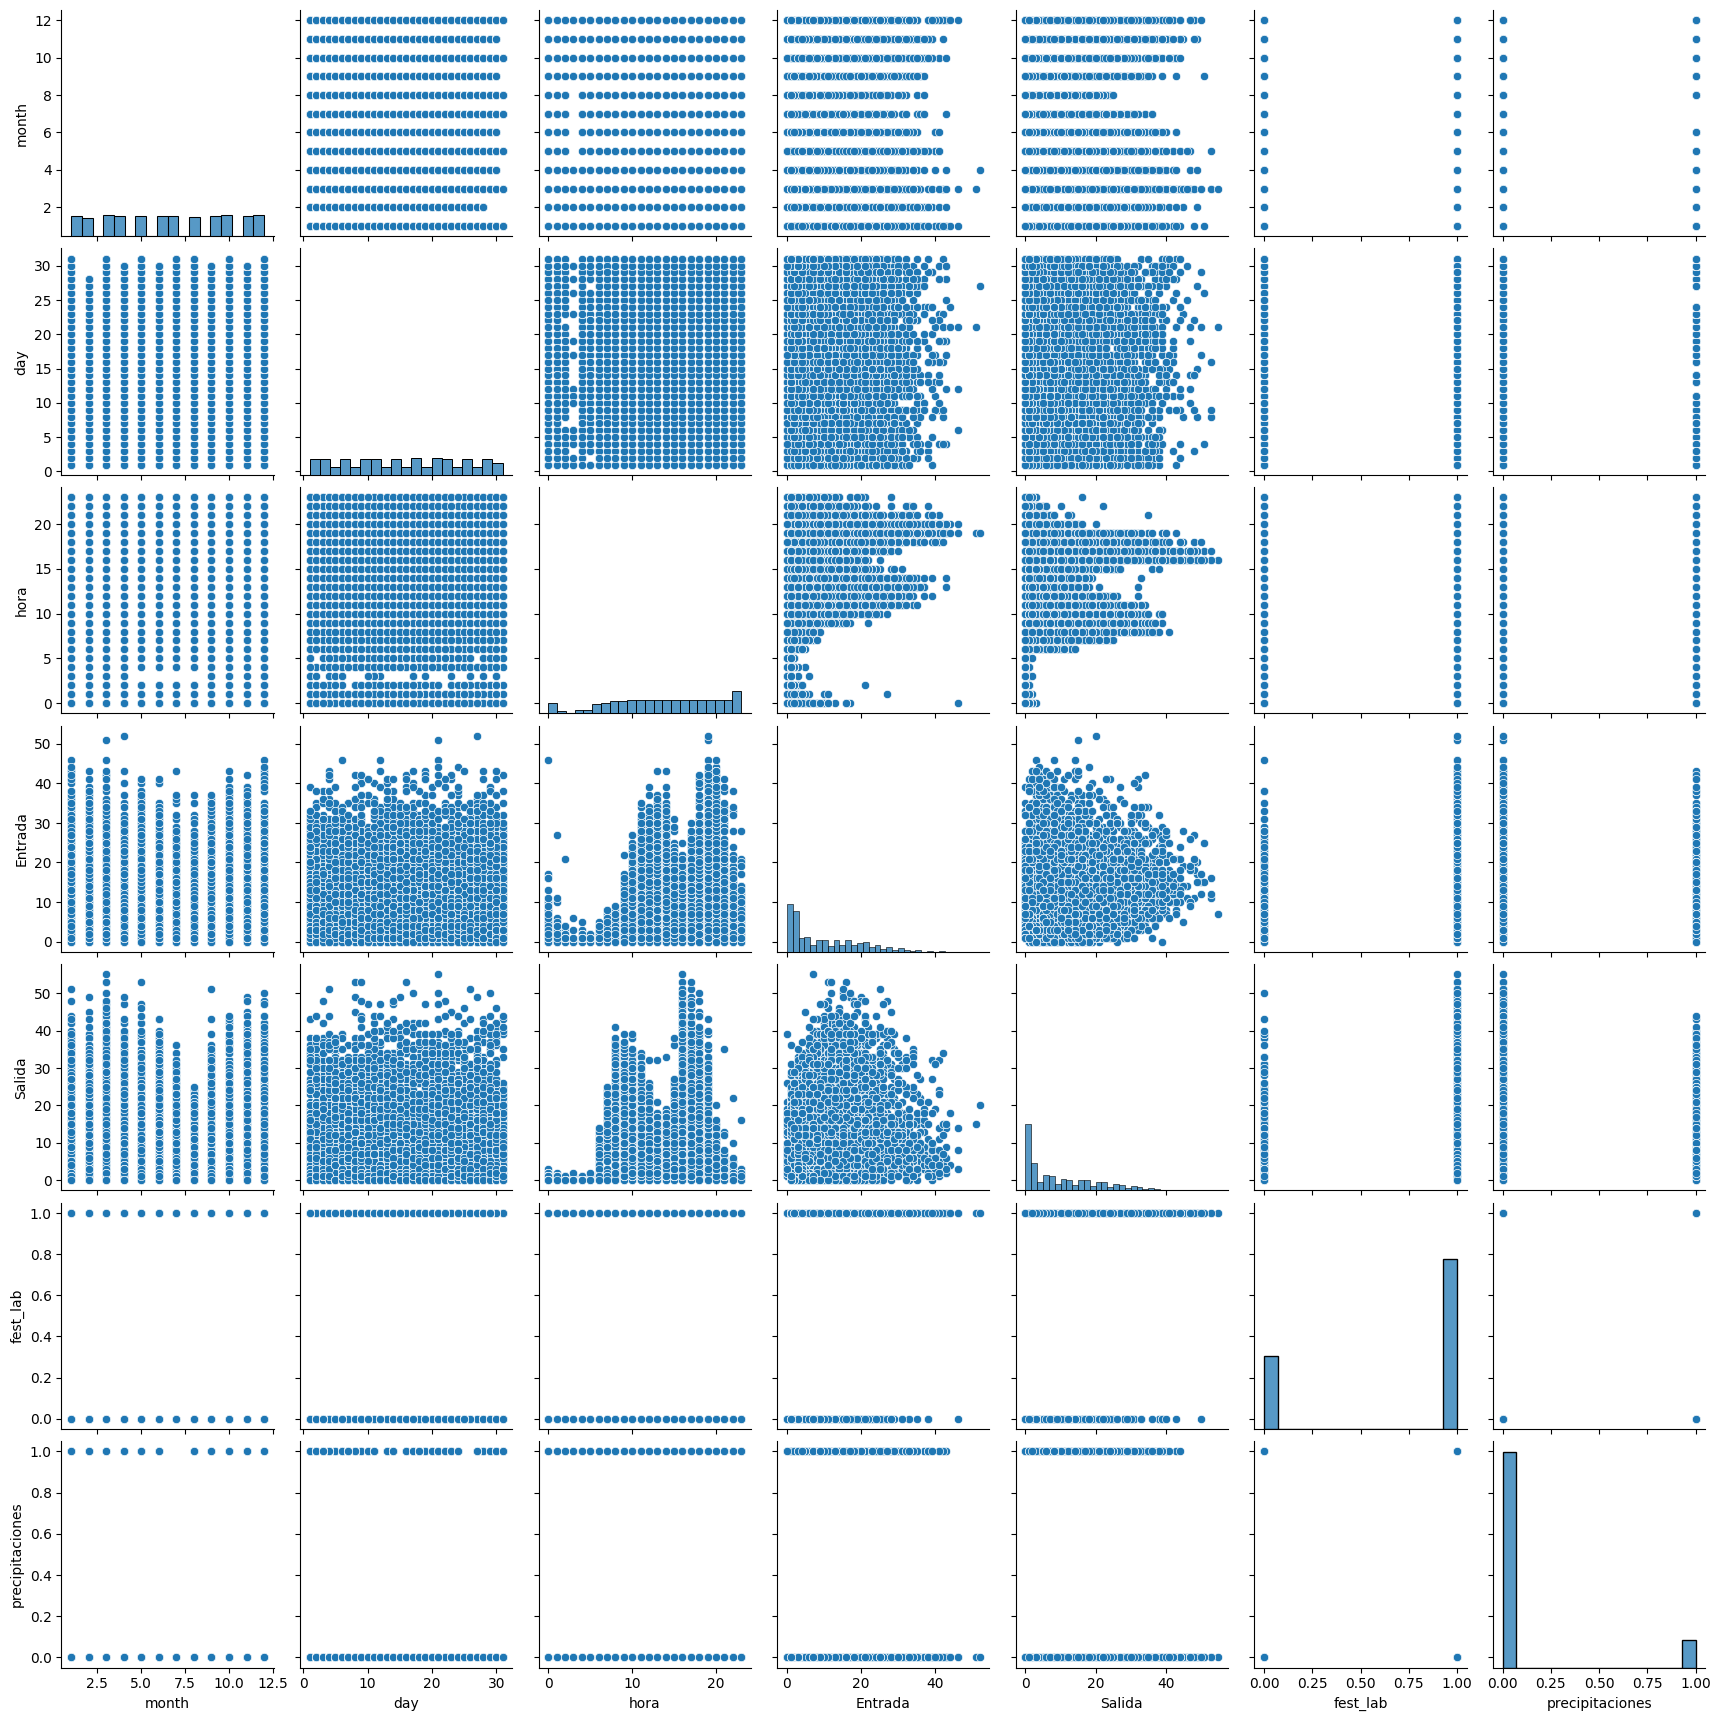

In [30]:
# Especifica las variables que deseas incluir en la matriz de dispersión
variables = ['month', 'day', 'hora', 'Entrada', 'Salida', 'fest_lab','precipitaciones']

sns.pairplot(df_final[variables])

# Matriz de dispersión
plt.show()



- Seleccionamos las variables para los conjuntos de datos, inicialemente cogeremos como variable objetivo "Entrada". Dejamos fuera las variables Aparcamiento y Salida ya que no hacen falta para realizar el entrenamiento.

In [31]:
# Dividimos los datos en características (X) y etiquetas (y)
X = df_final[['month', 'day', 'hora', 'fest_lab','precipitaciones']]
y = df_final['Entrada']
# y = df[['Entrada','Salida']]

In [32]:
X_values = X.values
X_values

array([[ 1,  1,  0,  0,  0],
       [ 1,  1,  1,  0,  0],
       [ 1,  1,  2,  0,  0],
       ...,
       [12, 31, 21,  0,  0],
       [12, 31, 22,  0,  0],
       [12, 31, 23,  0,  0]])

In [33]:
# Dividimos los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.2, random_state=42)

# Dividir los datos de entrenamiento nuevamente para obtener un conjunto de validación (60% train, 20% validation, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# El 25% de los datos de entrenamiento se convierten en validación


- Verificamos que los conjuntos de datos estan correctamente conformados.

In [34]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (4041, 5)
Dimensiones de X_val: (1347, 5)
Dimensiones de X_test: (1348, 5)
Dimensiones de y_train: (4041,)
Dimensiones de y_val: (1347,)
Dimensiones de y_test: (1348,)


-----------------------------

- Para el escalado, usaremos la librería MinMaxScaler de Scikit-Learn, ya que esta librería ajusta los valores de las características dentro del rango de 0 a 1. Como tenemos las columnas 'precipitaciones' y 'fest_lab' en modo binario, el uso de MinMaxScaler nos aventaa a la hora de preservar la distribución original de los datos.

In [35]:
# Escalamos los datos

# Inicializar el escalador
scaler = MinMaxScaler()

scaler.fit(X_train)

# Escalar los conjuntos de entrenamiento, validación y prueba
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# X_train_scaled,X_val_scaled,X_test_scaled

# Dendograma

- Se decide usar solo los datos de entrenamiento en lugar de todo el conjunto de datos del dataset, ya que esta técnica será más eficiente a la hora de evitar el sobreajuste que se puede dar debido al uso de los datos de prueba en la construcción del dendrograma, lo que podría arrojar resultados erróneos.

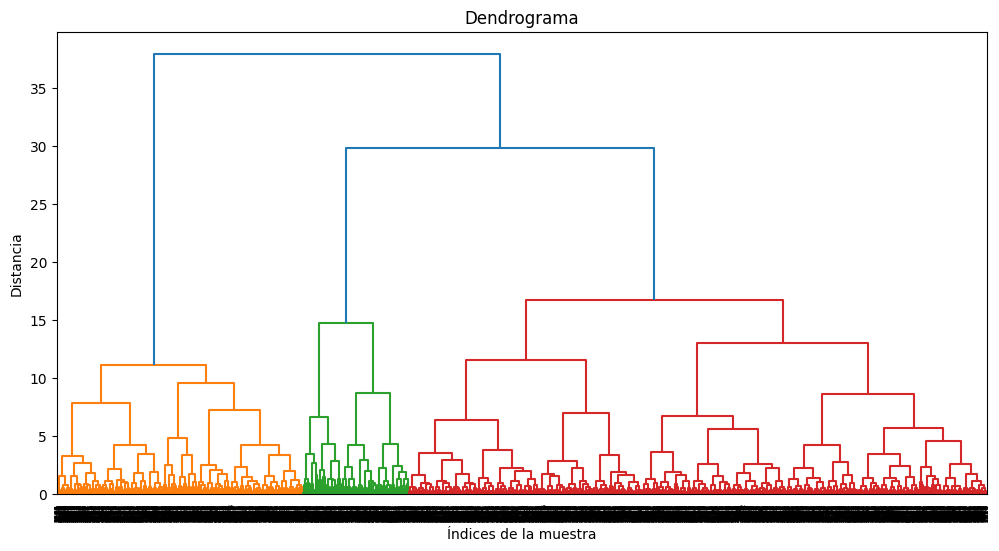

In [36]:
# Calcular la matriz de distancias entre los datos
distance_matrix = hierarchy.distance.pdist(X_train_scaled)

# Calcular el dendrograma
dendrogram = hierarchy.linkage(distance_matrix, method='ward')

# Visualizar el dendrograma
plt.figure(figsize=(12, 6))
hierarchy.dendrogram(dendrogram)
plt.title('Dendrograma')
plt.xlabel('Índices de la muestra')
plt.ylabel('Distancia')
plt.show()

--------------------------------

In [37]:
pip install lazypredict

In [38]:
from lazypredict.Supervised import LazyRegressor, LazyClassifier

# Inicializa LazyRegressor predictions=True,
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Ajustar LazyRegressor a los datos
models_summary, _ = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Muestra el resumen de los modelos
print(models_summary)


100%|██████████| 42/42 [00:40<00:00,  1.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 4041, number of used features: 5
[LightGBM] [Info] Start training from score 10.285573
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.82       0.82  4.18        2.98
LGBMRegressor                                0.82       0.82  4.18        0.13
XGBRegressor                                 0.81       0.81  4.28        0.21
RandomForestRegressor                        0.78       0.78  4.66        2.86
GradientBoostingRegressor                    0.77       0.77  4.71        0.42
BaggingRegressor                             0.76       0.76  4.85        0.10
KNeighborsRegressor          

# Resultados del lazypredict:
- Vemos como tres modelos HistGradientBoostingRegressor, LGBMRegressor y XGBRegressor, tienen los valores más altos de R^2 ajustado y R^2 (indican la varianza de la variable objetivo. Cuanto mas cercano a 1 mejor), entendemos que el ajuste de datos es correcto y hay una buena varianza de los datos.
- Estos modelos también tienen un RMSE relativamente bajo, (cuanto más cercano a 0 mejor), por lo que entiendo que las predicciones son muy ajustadas a la realidad.
- Por último, el tiempo de ajuste es bastante bajo de los modelos LGBMRegressor y XGBRegressor en comparación con otros modelos, por lo que teóricamente no debería llevar una carga computacional muy elevada a la hora de ejecutar los modelos. Sin embargo, se ve como el modelo que está en primer puesto, el HistGradientBoostingRegressor, es el segundo que más tarda en ejecutarse de entre todos los modelos cotejados. Por lo que no será nuestra primera opción para usar.

Librería H2O

In [39]:
pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.2-py2.py3-none-any.whl size=265365378 sha256=fbe277646ea1362d5d9e200704378ef0f6c2b03756f13ce381105e4ea3e584f6
  Stored in directory: /root/.cache/pip/wheels/63/14/f4/9fff736a0df59884631031b604e7b000a70409f5b7adafc2c6
Successfully built h2o


In [40]:
import h2o
from h2o.automl import H2OAutoML

# Inicializar H2O
h2o.init()

# Convertir y_train a una lista
y_train_list = y_train.tolist()

# Convertir los datos a H2OFrame
train_data = h2o.H2OFrame(X_train_scaled)
val_data = h2o.H2OFrame(X_val_scaled)
test_data = h2o.H2OFrame(X_test_scaled)

# Agregar la columna objetivo a train_data y val_data
train_data['Entrada'] = h2o.H2OFrame(y_train_list)
val_data['Entrada'] = h2o.H2OFrame(y_val.tolist())

# Definir columnas de entrada y columna objetivo
x = train_data.columns[:-1]
y = 'Entrada'

# Crear y entrenar un modelo AutoML
aml = H2OAutoML(max_models=20, seed=42)  # Ajuste del número máximo de modelos
aml.train(x=x, y=y, training_frame=train_data, validation_frame=val_data)

# Ver los modelos clasificados por rendimiento
lb = aml.leaderboard
print(lb)

# Obtener el modelo líder
best_model = aml.leader


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl5i7x4s0
  JVM stdout: /tmp/tmpl5i7x4s0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl5i7x4s0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_unknownUser_aus4ef
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:15:25.659: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse      mse      mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_2

# Resultados H2O y comparativa con resultados de LazyPredict para el dataset de mata

Podemos ver cuales modelos son los que mejor se ajustan al conjunto de datos observando las métricas RMSE,MSE y MAE. Estas métricas miden la diferencia entre los valores predichos por el modelo y los valores reales en el conjunto de datos y cuanto mas cercanas a 0, mejor será el valor predictivo de entrada de vehículos del modelo en cuestion.

- Stacked Ensemble All Models: Según H2O, este modelo es el que se podría entender como el mejor candidato debido a que es el que tiene las métricas más bajas:
    - RMSE: 4.4911
    - MSE: 20.17
    - MAE: 3.08564

En contra tiene que no estoy familiarizado con este tipo de modelos denominados "Ensemble o de ensamblaje", los cuales en vez de depender de un solo modelo para hacer predicciones, usan una combinación de distintos modelos más simples para mejorar el rendimiento y por ende, la precisión general del modelo. Si bien se procederá a una investigación para probarlo, inicialmente no será una de las primeras opciones a elegir.

GBM y XGBoost: tal y como nos indicó el LazyPredict estos modelos han demostrado un buen rendimiento en sus métricas, por lo que pasaré a probarlos para tomar una decisión en base a los resultados obtenidos

  - GBM:
    - RMSE: 4.52827
    - MSE: 20.5052
    - MAE: 3.13412

  - XGBoost:
    - RMSE: 4.65399
    - MSE: 21.6596
    - MAE: 3.23277

En ámbitos generales estudiando las métricas de los tres modelos principales podemos comcluir que:
  - El resultado de la raiz cuadrada del error cuadrático medio nos indica que los modelos pueden tener una calidad a la hora de realizar las predicciones bastante acertada.
  - Con respecto al error cuadrático medio (MSE), indica cierta precisión a la hora de realizar las predicciones.
  - Finalmente el error absoluto medio (MAE), nos muestra que tiene una mayor variabilidad en las predicciones.
  - Con respecto a los tiempos de ejecución nos muestra un rendimiento computacional razonable.

# Elección de modelos
- XGBRegressor

Uso de selector de características
RandomizedSearchCV de la librería Scikit Learn

In [41]:
# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Creamos el objeto XGBRegressor
xgb_model = XGBRegressor()

# CrossValidation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creamos el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=50, scoring='neg_mean_squared_error',
                                   cv=kf, verbose=2, random_state=42, n_jobs=-1)

# Ajustamos RandomizedSearchCV al conjunto de entrenamiento
random_search.fit(X_train_scaled, y_train)

# Obtener los mejores hiperparámetros y el mejor estimador
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Finalmente se muestran los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros encontrados:
{'subsample': 1.0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}


En base a los hiperparámetros que hemos descubierto

In [42]:
# Creamos el modelo XGBRegressor con los mejores hiperparámetros y con regularización L1 y L2
xgb_model = XGBRegressor(subsample=1.0, n_estimators=500, max_depth=6,
                         learning_rate=0.1, gamma=0.2, colsample_bytree=0.6,
                         reg_alpha=1, reg_lambda=1)

# Realizamos la validación cruzada
cv_results = cross_validate(xgb_model, X_train_scaled, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Obtenemos las puntuaciones de entrenamiento y prueba
train_rmse_scores = np.sqrt(-cv_results['train_neg_mean_squared_error'])
test_rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
train_r2_scores = cv_results['train_r2']
test_r2_scores = cv_results['test_r2']

# Imprimimos los resultados de la validación cruzada
print("Resultados de la validación cruzada:")
print("RMSE en entrenamiento:", train_rmse_scores.mean())
print("RMSE en prueba:", test_rmse_scores.mean())
print("R^2 en entrenamiento:", train_r2_scores.mean())
print("R^2 en prueba:", test_r2_scores.mean())

Resultados de la validación cruzada:
RMSE en entrenamiento: 3.601212465645486
RMSE en prueba: 4.476779964413021
R^2 en entrenamiento: 0.8608943248237921
R^2 en prueba: 0.7847643588977821


- Vemos como el conjunto de prueba tiene un error cuadrático medio de 4.24, por lo que se puede observar como el modelo está haciendo predicciones bastante precisas, indicando a su vez, que los hiperparámetros escogidos son los adecuados para este problema de regresión.

# Realización de predicciones del modelo

In [77]:
# Ajustamos el modelo al conjunto de entrenamiento
xgb_model.fit(X_train, y_train)

# Predecimos los valores en el conjunto de prueba, validación y entrenamiento
y_pred_test_xgb_model = xgb_model.predict(X_test).round().astype(int)
y_pred_val_xgb_model = xgb_model.predict(X_val).round().astype(int)
y_pred_train_xgb_model = xgb_model.predict(X_train).round().astype(int)

# Creamos DataFrames con las predicciones
predictions_df_test_xgb_model = pd.DataFrame({'Predicciones_Entradas conjunto test': y_pred_test_xgb_model})
predictions_df_val_xgb_model = pd.DataFrame({'Predicciones_Entradas conjunto val': y_pred_val_xgb_model})
predictions_df_train_xgb_model = pd.DataFrame({'Predicciones_Entradas conjunto train': y_pred_train_xgb_model})

# Imprimimos las predicciones
print("Predicciones en conjunto de prueba:")
print(predictions_df_test_xgb_model)
print("\nPredicciones en conjunto de validación:")
print(predictions_df_val_xgb_model)
print("\nPredicciones en conjunto de entrenamiento:")
print(predictions_df_train_xgb_model)

Predicciones en conjunto de prueba:
      Predicciones_Entradas conjunto test
0                                       2
1                                      -1
2                                       1
3                                       1
4                                       5
...                                   ...
1343                                    5
1344                                    1
1345                                    5
1346                                    2
1347                                    1

[1348 rows x 1 columns]

Predicciones en conjunto de validación:
      Predicciones_Entradas conjunto val
0                                      1
1                                      1
2                                      1
3                                      1
4                                      1
...                                  ...
1342                                   1
1343                                  -1
1344                     

In [79]:
# Realizamos predicciones en el conjunto de prueba
y_pred_test_xgb_model = xgb_model.predict(X_test).round().astype(int)

# Calculamos métricas adicionales
mae_test = mean_absolute_error(y_test, y_pred_test_xgb_model)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test_xgb_model)

print(f"MAE en conjunto de prueba: {mae_test}")
print(f"MAPE en conjunto de prueba: {mape_test}")

MAE en conjunto de prueba: 2.9896142433234423
MAPE en conjunto de prueba: 628098464351375.2


In [80]:
# Realizamos predicciones en el conjunto de validación
y_pred_val_xgb_model = xgb_model.predict(X_val).round().astype(int)

# Calculamos métricas adicionales
mae_val = mean_absolute_error(y_val, y_pred_val_xgb_model)
mape_val = mean_absolute_percentage_error(y_val, y_pred_val_xgb_model)

print(f"MAE en conjunto de validación: {mae_val}")
print(f"MAPE en conjunto de validación: {mape_val}")

MAE en conjunto de validación: 3.0215293244246473
MAPE en conjunto de validación: 424615555067597.44


------------------------

Se puede interpretar que se está sobreajustando el modelo, probablemente por haber reducido tanto el conjunto de datos, en el mejor de los casos y según el aparcamiento, puede alcanzar las 8000 filas.

-----------------------

# Prueba con Modelo RandomForestRegressor


In [46]:
# # Definimos el espacio de búsqueda de hiperparámetros
# param_grid = {
#     'n_estimators': [300, 500, 700, 900, 1000],
#     'max_depth': [2, 5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Inicializar el modelo RandomForestRegressor
# rf_model = RandomForestRegressor(random_state=42)

# # CrossValidation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Realizar la búsqueda de hiperparámetros
# rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
#                                n_iter=50, cv=kf, verbose=2, random_state=42, n_jobs=-1)

# # Ajustar la búsqueda de hiperparámetros al conjunto de entrenamiento
# rf_random.fit(X_train_scaled, y_train)

# # Mostrar los mejores hiperparámetros encontrados
# print("Mejores hiperparámetros encontrados:")
# print(rf_random.best_params_)



In [ ]:
# # Definimos el modelo RandomForestRegressor
# rf_model = RandomForestRegressor(n_estimators=900, min_samples_split=5, min_samples_leaf=1,
#                                 max_features='log2', max_depth=20, random_state=42)

# # Definimos las métricas de evaluación
# scoring = ('neg_mean_squared_error', 'r2')

# # Realizamos la validación cruzada con 5 pliegues
# cv_results = cross_validate(rf_model, X_train_scaled, y_train, cv=5,
#                             scoring=scoring,
#                             return_train_score=True)

# # Accedemos a los resultados de la validación cruzada
# train_rmse = np.sqrt(-cv_results['train_neg_mean_squared_error'].mean())
# test_rmse = np.sqrt(-cv_results['test_neg_mean_squared_error'].mean())
# train_r2 = cv_results['train_r2'].mean()
# test_r2 = cv_results['test_r2'].mean()

# print("Resultados de la validación cruzada:")
# print("RMSE promedio en entrenamiento:", train_rmse)
# print("RMSE promedio en validación cruzada:", test_rmse)
# print("R2 promedio en entrenamiento:", train_r2)
# print("R2 promedio en validación cruzada:", test_r2)

In [ ]:
# # Ajustamos el modelo al conjunto de entrenamiento
# rf_model.fit(X_train_scaled, y_train)

# # Predecimos los valores en el conjunto de prueba
# y_pred = rf_model.predict(X_test_scaled)

# # Calculamos el error cuadrático medio en el conjunto de prueba
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print("RMSE en el conjunto de prueba:", rmse)

In [ ]:
# # Utilizamos el modelo entrenado para hacer predicciones
# y_pred_test_rf_model = rf_model.predict(X_test_scaled).round().astype(int)
# y_pred_val_rf_model = rf_model.predict(X_val_scaled).round().astype(int)
# y_pred_train_rf_model = rf_model.predict(X_train_scaled).round().astype(int)

# # Creamos un DataFrame con las predicciones
# predictions_df_test_rf_model = pd.DataFrame({'Pred_test': y_pred_test_rf_model})
# predictions_df_val_rf_model = pd.DataFrame({'Pred_val': y_pred_val_rf_model})
# predictions_df_train_rf_model = pd.DataFrame({'Pred_train': y_pred_train_rf_model})

# # Imprimimos las predicciones
# print(predictions_df_test_rf_model,"\n", predictions_df_val_rf_model,"\n",predictions_df_train_rf_model)

In [ ]:
# # Calculamos métricas adicionales
# mae_test = mean_absolute_error(y_test, y_pred_test_rf_model)
# mape_test = mean_absolute_percentage_error(y_test, y_pred_test_rf_model)

# print(f"MAE en conjunto de prueba: {mae_test}")
# print(f"MAPE en conjunto de prueba: {mape_test}")

In [ ]:
# # Calculamos métricas adicionales
# mae_val = mean_absolute_error(y_val.tolist(), y_pred_val_rf_model)
# mape_val = mean_absolute_percentage_error(y_val.tolist(), y_pred_val_rf_model)

# print(f"MAE en conjunto de validación: {mae_val}")
# print(f"MAPE en conjunto de validación: {mape_val}")

# Prueba de predicción
- Con XgbRegressor

In [51]:
x_in = np.asarray([5, 2, 20, 1, 0]).reshape(1,-1)

predicts_In = xgb_model.predict(x_in)

pred = np.round(predicts_In).astype(int)
print (f'Cantidad de entradas: {pred[0]}')

Cantidad de entradas: 27


---------------------------------------------

Cálculo con SMAPE para el tratamiento de ceros

In [54]:
# # Función para calcular SMAPE
# def smape(y_true, y_pred):
#     return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# # Inspección de los valores de y_test
# print(f"Valores mínimos en y_test: {np.min(y_test)}")

# # Calcular MAE
# mae_test = mean_absolute_error(y_test, y_pred_test_rf_model)

# # Verificar si hay valores muy pequeños o ceros en y_test
# if np.min(y_test) <= 1e-6:
#     print("Advertencia: Hay valores muy pequeños o ceros en y_test. Usando SMAPE en lugar de MAPE.")
#     mape_test = smape(y_test, y_pred_test_rf_model)
# else:
#     from sklearn.metrics import mean_absolute_percentage_error
#     mape_test = mean_absolute_percentage_error(y_test, y_pred_test_rf_model)

# print(f"MAE en conjunto de prueba: {mae_test}")
# print(f"MAPE en conjunto de prueba: {mape_test}")


In [55]:
# ###########BUSCAR VALORES NEGATVOS O CEROS EN EL DF##############
# df_y_val = pd.DataFrame(y_val)

# # Iterar sobre el DataFrame para encontrar los valores menores de cero
# count = 0
# for index, row in df_y_val.iterrows():
#     for column in df_y_val.columns:
#         if row[column] < 0 or row[column] == 0:
#           count += 1
#           # print(f"Valor menor de cero: {row[column]} en la fila {index}, columna '{column}'")

# print("Total de ceros en el conjutno de test = ", count)

-------------------------------------------

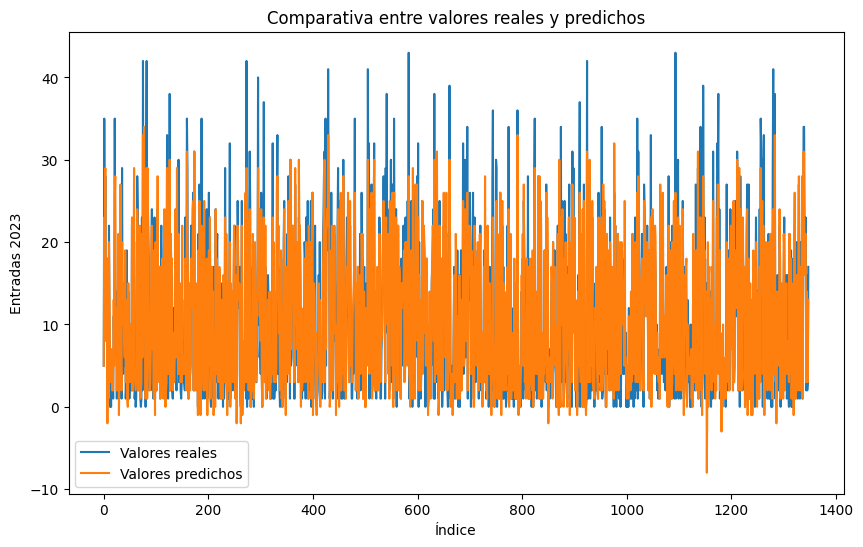

In [62]:
# Comparativa entre los valores reales y los valores predichos 2023
plt.figure(figsize=(10, 6))
plt.plot(y_test.to_list(), label='Valores reales')
plt.plot(y_pred_test_xgb_model, label='Valores predichos')
plt.xlabel('Índice')
plt.ylabel('Entradas 2023')
plt.title('Comparativa entre valores reales y predichos')
plt.legend()
plt.show()


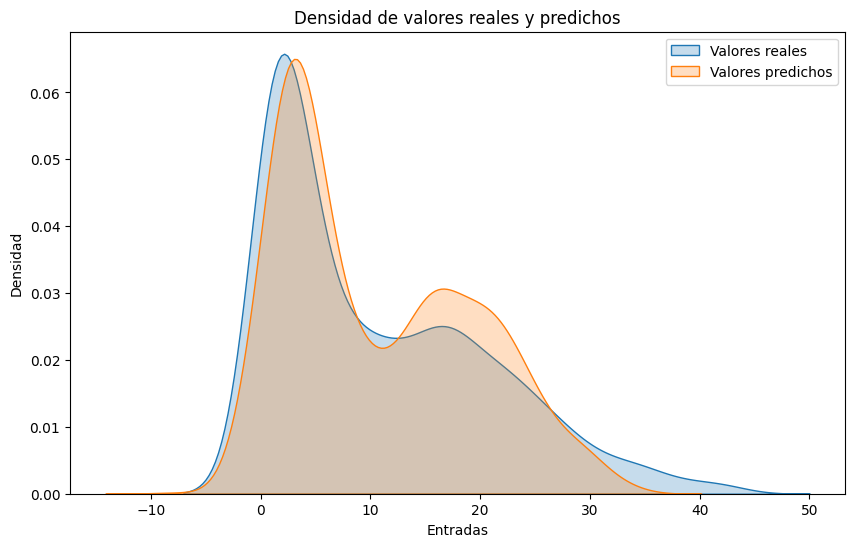

In [63]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test.to_list(), label='Valores reales', shade=True)
sns.kdeplot(y_pred_test_xgb_model, label='Valores predichos', shade=True)
plt.xlabel('Entradas')
plt.ylabel('Densidad')
plt.title('Densidad de valores reales y predichos')
plt.legend()
plt.show()


In [61]:
from xgboost import plot_importance

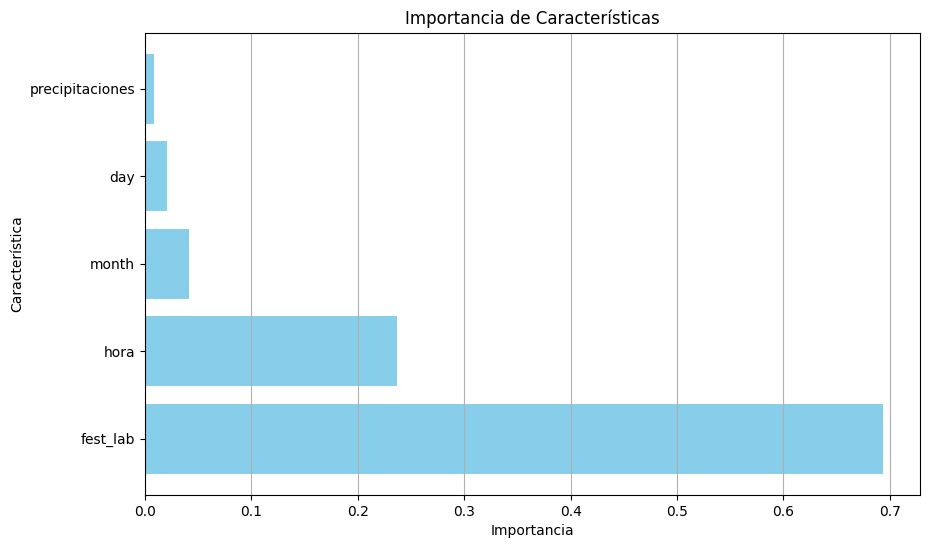

In [89]:
feature_names = X.columns
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'],feature_importance_df['Importance'],color='skyblue')
plt.title("Importancia de Características")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.grid(axis='x')
plt.show()

# Puesta en producción

Descarga de los modelos entrenados

In [ ]:
# Guardar el modelo XGBoost en un archivo
# joblib.dump(xgb_model, f'xgb_trained_model_{nombre_aparcamiento}.pkl')
# files.download(f'xgb_trained_model_{nombre_aparcamiento}.pkl')

In [ ]:
# Guardar el modelo Random Forest en un archivo
# joblib.dump(rf_model, f'rf_trained_model_{nombre_aparcamiento}.pkl')
# files.download(f'rf_trained_model_{nombre_aparcamiento}.pkl')
